<a href="https://colab.research.google.com/github/peeush-the-developer/LGMVIP-DataScience/blob/main/Handwritten-Math-Equation-Solver/1_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Math Equation solver

We can approach this problem statement in the following steps:

1. We are given a dataset of images for different Math symbols using which we can train our Image classification model to classify images as math symbols.
2. Next, we take an image with complete math equation and try to segregate each symbol into smaller images
3. Pass these smaller images to find the actual symbol and then solve the equation as a normal math equation.

Easy huh!

Let's get started!

## Download the dataset with math symbol images

This is the [Dataset link](https://www.kaggle.com/xainano/handwrittenmathsymbols) which contains `data.rar` file and unzip the file after downloading.

The dataset contains different images for each math symbol as well as alphanumeric characters.

In this notebook, we'll get familarize with the dataset.

Understand the folder structure and plot random images to get basic understanding about the images.

In [1]:
# Import libraries
import os
import random

import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cv2.__version__

'4.5.0'

In [3]:
input_folder = 'data/input_images'

For simplicity of the notebook, we have extracted images only for 0-9 numeric digits and operations, '=', '+', '-', 'div', 'times'.

In [4]:
folder_names = [folder for folder in os.listdir(input_folder)]
print(sorted(folder_names))

['+', '-', '.DS_Store', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'div', 'times']


In [5]:
base_folder = os.path.join('data', 'input_images')

In [6]:
def load_image_random(folder_name):
    '''
    Random image from the specified folder

    Arguments:
      folder_name: Specific folder name from which the image is picked

    Returns:
      Image in grayscale in the form of Numpy 2D array
    '''
    folder = os.path.join(base_folder, folder_name)
    # print(folder)
    img_files = os.listdir(folder)
    rand_index = np.random.randint(len(img_files))
    # print(rand_int, img_files[rand_index])
    img = cv2.imread(os.path.join(folder, img_files[rand_index]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, rand_index

In [7]:
def display_image(imgray):
    '''
    Plot an image

    Arguments:
      imgray: Image in grayscale i.e. Numpy 2D array
    '''
    plt.imshow(imgray, cmap='gray')
    plt.axis('off')
    plt.show()

In [8]:
def display_image_grid(imgray1, imgray2):
    '''
    Plot an image grid with 2 images

    Arguments:
      imgray1: Image in grayscale i.e. Numpy 2D array
      imgray2: Image in grayscale i.e. Numpy 2D array
    '''
    plt.subplot(121)
    plt.imshow(imgray1, cmap='gray')
    plt.axis('off')
    plt.title("Image 1")
    
    plt.subplot(122)
    plt.imshow(imgray2, cmap='gray')
    plt.axis('off')
    plt.title("Image 2")
    
    plt.show()

In [9]:
def resize_image(imgray, resize=(28,28)):
    '''
    Resize the image by finding contours around the math symbol and then resize it to 28x28 shape

    Arguments:
      imgray: Image in grayscale

    Returns:
      Resized image of 28x28 shape
    '''
    ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # print('Number of contours:', len(contours))
    # print(hierarchy.shape)
    cnt = sorted(contours, key = lambda ctr: cv2.boundingRect(ctr)[0])
    w, h = resize
    max_size = 0
    for c in cnt:
        x, y, w, h = cv2.boundingRect(c)
        # print(x, y, w, h)
        max_size = max(w*h, max_size)
        if max_size == w*h:
            x_max = x
            y_max = y
            w_max = w
            h_max = h
    cropped_img = thresh[y_max:y_max+h_max+10, x_max:x_max+w_max+10]
    resized_img = cv2.resize(cropped_img, resize)
    # print(imgray.shape)
    # print(resized_img.shape)
    # resized_img=np.reshape(resized_img,(784,1))
    return resized_img

In [10]:
def display_result(folder_name):
    imgray, index = load_image_random(folder_name)
    print('Image at index', index, ' in', folder_name, 'is:')
    img_bb = resize_image(~imgray)
    display_image_grid(~imgray, img_bb)
    # display_image(imgray)
    # display_image(img_bb)

Image at index 700  in 0 is:


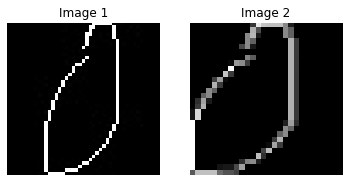

In [11]:
display_result('0')

Image at index 1010  in times is:


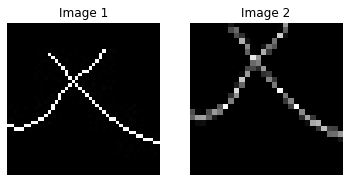

In [12]:
display_result('times')

In [16]:
print(base_folder)
print(os.listdir(base_folder))
ds_store = os.path.join(base_folder, '.DS_Store')
os.path.isdir(ds_store)

data/input_images
['.DS_Store', 'div', 'times', '9', '0', '7', '+', '6', '1', '8', '-', '=', '4', '3', '2', '5']


False

In [18]:
# Check no. of images in each class
items_count_dict = {}
for folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder)
    if not os.path.isdir(folder_path):
        continue
    items = os.listdir(folder_path)
    items_count_dict[folder] = len(items)

sorted_items = sorted(items_count_dict.items(), key=lambda x:x[1])
items_count_dict_sorted = dict(sorted_items)
items_count_dict_sorted.items()

dict_items([('div', 868), ('7', 2909), ('8', 3068), ('6', 3118), ('times', 3251), ('5', 3545), ('9', 3737), ('0', 6914), ('4', 7396), ('3', 10909), ('=', 13104), ('+', 25112), ('2', 26141), ('1', 26520), ('-', 33997)])

In [19]:
# To keep the sample size limited, we take <4000 images randomly for each class.
threshold = 4000

In [20]:
items_count_dict = {}

# Iterate over all classes folders
for folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder)
    if not os.path.isdir(folder_path):
        continue

    # fetch filenames in the class folder
    items = os.listdir(folder_path)
    
    # vars for bookeeping
    items_orig_len = len(items)
    deleted_files_len = 0

    if len(items) > threshold:
        # Fetch random filenames upto threshold from all filenames
        random_files = random.sample(items, threshold)
        # Take difference of filenames to be deleted
        to_delete_files = set(items) - set(random_files)
        
        # vars for bookeeping
        deleted_files_len = len(to_delete_files)
        # Delete files (not selected in random sampling)
        for item in to_delete_files:
            os.remove(os.path.join(folder_path, item))


    # fetch filenames in the class folder again
    items = os.listdir(folder_path)
    # Print resultant metric for the class folder
    print(folder, items_orig_len, deleted_files_len, len(items))

    # Add items len in the dict
    items_count_dict[folder] = len(items)

# Print the dictionary with len of items in each class folder
print(items_count_dict.items())

div 868 0 868
times 3251 0 3251
9 3737 0 3737
0 6914 2914 4000
7 2909 0 2909
+ 25112 21112 4000
6 3118 0 3118
1 26520 22520 4000
8 3068 0 3068
- 33997 29997 4000
= 13104 9104 4000
4 7396 3396 4000
3 10909 6909 4000
2 26141 22141 4000
5 3545 0 3545
dict_items([('div', 868), ('times', 3251), ('9', 3737), ('0', 4000), ('7', 2909), ('+', 4000), ('6', 3118), ('1', 4000), ('8', 3068), ('-', 4000), ('=', 4000), ('4', 4000), ('3', 4000), ('2', 4000), ('5', 3545)])
